KEJSI KALLIRI - Master of Artificial Intelligence and Optimization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#libraries
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
from skimage.color import rgb2gray, label2rgb
from skimage.util import random_noise
from skimage.measure import label
from skimage.filters import gaussian, prewitt,roberts,sobel,threshold_otsu, threshold_multiotsu
from skimage import exposure
import seaborn as sns
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import regionprops, regionprops_table

from skimage import data, img_as_uint, img_as_ubyte

from skimage.data import binary_blobs
from skimage.morphology import erosion, disk, dilation

from scipy import ndimage
import math

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report

Image shape : (303, 384) 
Image data type : uint8
Pixel range: [1, 252]


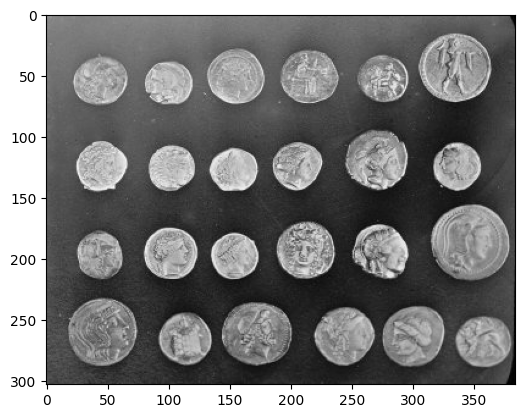

In [ ]:
#Load and visualize the 'coins' image from the skimage built-in datasets.
#Report the size of the image and range of the pixel grayscale levels.

from skimage import data
import matplotlib.pyplot as plt

I = data.coins()
plt.imshow(I, cmap='gray')
# I.shape
# I.dtype

print('Image shape : {} \nImage data type : {}'.format(I.shape,I.dtype))
print(f"Pixel range: [{I.min()}, {I.max()}]")

Text(0.5, 1.0, 'Histogram')

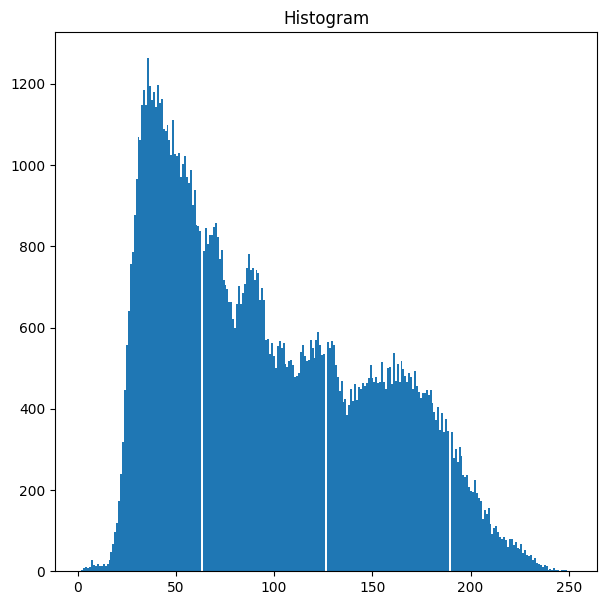

In [ ]:
#Represent the histogram of the image. Explain the peaks of the histogram in terms of regions of the image.

fig = plt.figure(figsize=(7,7))
plt.hist(I.ravel(),bins=255,density=False)
plt.title('Histogram')


# Left Peak (~0–50): Represents dark regions (e.g., background or shadows)
# Right Peak (~150–250): Represents bright regions (e.g., coins or reflective surfaces)
# Low Frequencies in Mid-Range (50–150): Few pixels in mid-tones, indicating high contrast between coins and background

# High Contrast: The coins stand out clearly against the dark background
# Bimodal Distribution: Ideal for thresholding (e.g., using Otsu’s method to separate coins from background)
# No Saturation: No spikes at 0 or 255, so no over/under-exposed areas

([], [])

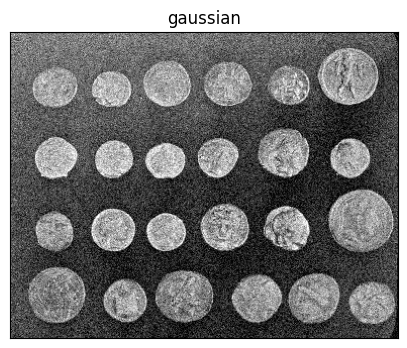

In [ ]:
#Applied noise to the image and use the correct function to erase the noise.
#(I am supposing this task requires to use just one noise mode, if others are required is approximately the same as exercise 1 we have done in seminars)

noisy_image = random_noise(I,mode='gaussian')

fig = plt.figure(figsize=(5,5))
plt.imshow(noisy_image,cmap='gray')
plt.title('gaussian')
plt.xticks([])
plt.yticks([])

([], [])

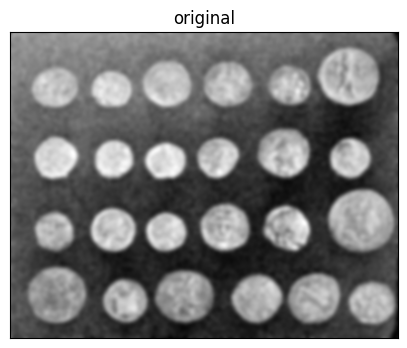

In [ ]:
img = gaussian(noisy_image,2) #i am using sigma=2

fig = plt.figure(figsize=(5,5))
plt.imshow(img,cmap='gray')
plt.title('original')
plt.xticks([])
plt.yticks([])

# Image becomes more blurred, smoothing out the noise
# but also potentially losing fine details in the image.

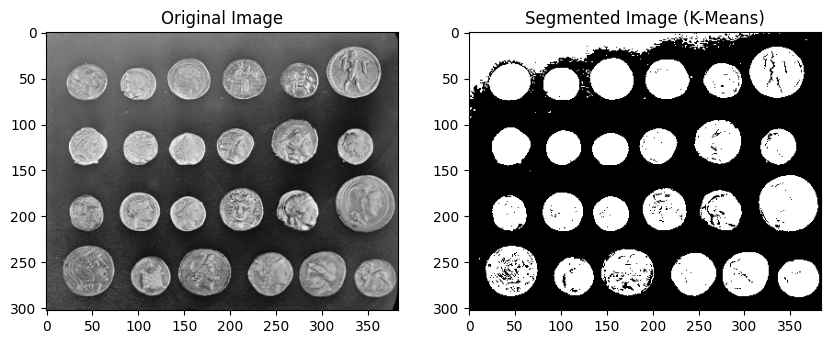

In [ ]:
#Segment the image using a k-means clustering algorithm with k=2 and represent the result

from sklearn.cluster import KMeans

v_I = I.reshape(I.shape[0]*I.shape[1],1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(v_I)
segmented_image = kmeans.labels_.reshape(I.shape[:2])

# Display results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(I,cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(segmented_image, cmap='gray')
axes[1].set_title('Segmented Image (K-Means)')
plt.show()

# Evaluation of results
# K-Means groups pixels into clusters based on their color similarity.
# KMeans segments the grayscale image into 2 clusters based on intensity values.
# The segmentation is relatively sharp but can create abrupt transitions.
# Since KMeans assumes spherical clusters with equal variance, the results are sometimes less accurate in complex images.

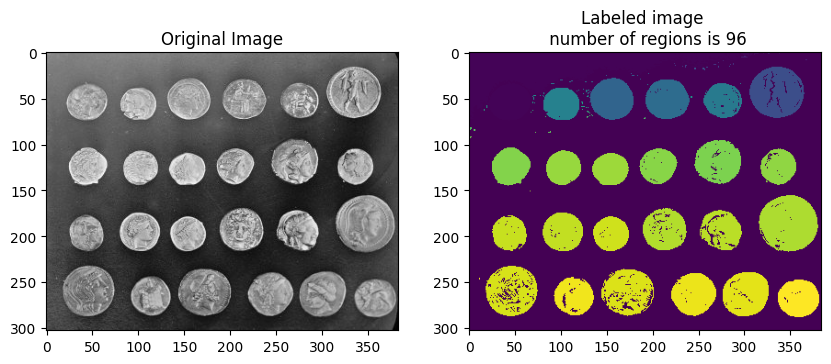

Number of coins in the image are 24 but number of coins in labeled image are 23


In [ ]:
 #Label the objects found in the image. Generate a figure with the original image and the labeled image. How many coins are there in the image?

from skimage.measure import label

t = threshold_otsu(I)
binary = I > t

label_image, nregions = label(binary,return_num=True)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(I,cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(label_image)
axes[1].set_title('Labeled image \n number of regions is {}'.format(nregions))
plt.show()

print('Number of coins in the image are 24 but number of coins in labeled image are 23')

#Explanation:
#Number of coins : 23 , Number of regions : 96
# The discrepancy occurs because the label() function counts all connected regions in the binary image, including:
# Actual coins (the 23 large objects i expect).
# Noise or small artifacts (for example tiny blobs from imperfect thresholding, dust, or texture).
# Fragmented regions (if coins are partially merged or thresholding splits them).

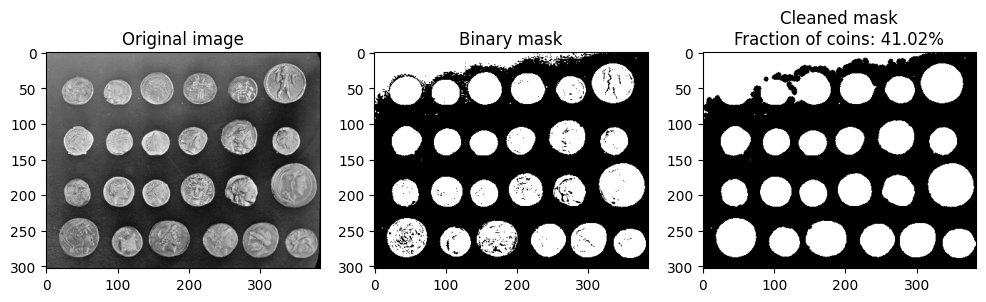

In [ ]:
#i am also finding the fraction of coins

from skimage import morphology

#segment the image
thresh = threshold_otsu(I)
binary = I > thresh
cleaned = morphology.binary_closing(binary, morphology.disk(3))  #i am using this to remove small objects from the image

total_pixels = I.size
coin_pixels = np.sum(cleaned)    #summ all 1's
fraction = coin_pixels / total_pixels

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap='gray')
ax[1].set_title('Binary mask')

ax[2].imshow(cleaned, cmap='gray')
ax[2].set_title(f'Cleaned mask\nFraction of coins: {fraction:.2%}')

plt.show()

In [ ]:
#Extract the area, major axis length and orientation of each coin.
props = regionprops_table(label_image,properties=['label','area','axis_major_length','orientation'])

df_features = pd.DataFrame(props)
df_features.head()

,label,area,axis_major_length,orientation
0,1,8792.0,292.106573,-1.423583
1,2,37.0,14.020584,1.524098
2,3,21.0,16.645960,-1.508404
3,4,1.0,0.000000,-0.785398
4,5,2.0,2.000000,0.000000


In [ ]:
#Report the average values of the extracted features.
mean_area = df_features['area'].mean()
mean_axis_major_length = df_features['axis_major_length'].mean()
mean_orientation = df_features['orientation'].mean()

print('Mean area :  {} \nMean axis major length : {} \nMean orientation : {} '.format(mean_area,mean_axis_major_length,mean_orientation))

Mean area :  469.96875 
Mean axis major length : 15.758363582402723 
Mean orientation : -0.1608039190057604 


<Axes: xlabel='area', ylabel='axis_major_length'>

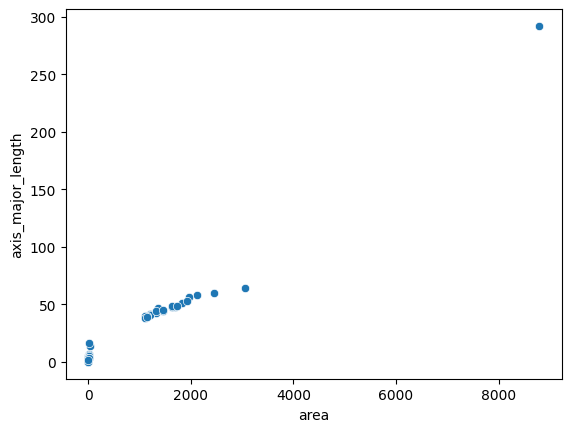

In [ ]:
#Represent a scatterplot of the area vs major axis length
sns.scatterplot(x='area',y='axis_major_length',data=df_features)

# Key Observations:
# X-axis (axis_major_length): Ranges from 0 to ~8000 (pixels or arbitrary units).
# Y-axis (area): Ranges from 0 to 300 (pixels or normalized units).

# Point Distribution:
# Most points cluster in the lower-left corner (small area and short major axis).
# A few points extend to higher axis_major_length but remain low in area, suggesting long, thin objects.
#Also there is not a clear correlation between coins's axis major length and area.
# The point distribution suggests that the relationship is not purely linear.

In [ ]:
# Using the labeled regions from the 'coins' image, how can I filter the regions to find those with an area greater than 1750 pixels, count how many such coins there are?

df_large_coins = df_features.loc[df_features['area']>=1750]
N_large = df_large_coins.shape[0]
print('There are {} coins with an area larger or equal to 1750 pixels'.format(N_large))

df_small_coins = df_features.loc[df_features['area']<1750]
N_small = df_small_coins.shape[0]
print('There are {} coins with an area smaller than 1750 pixels'.format(N_small))

There are 7 coins with an area larger or equal to 1750 pixels
There are 89 coins with an area smaller than 1750 pixels


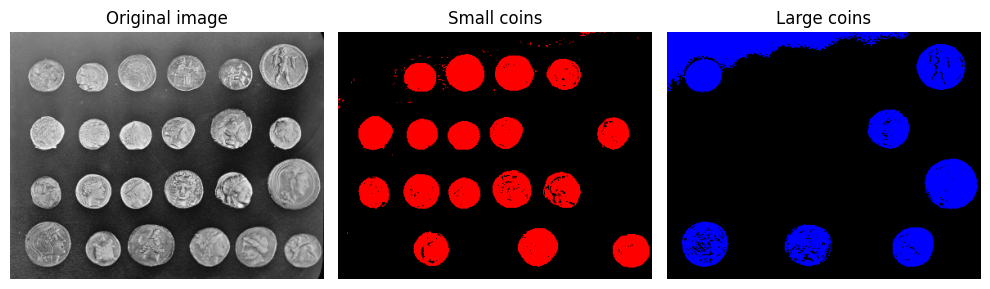

In [ ]:
#Generate a 3-panel figure with the original image,
#the image with the little coins < 1750 coins (red color)
#and an image with the big coins > 1750 (blue color).

from matplotlib.colors import ListedColormap

cmap_red = ListedColormap(['black', 'red'])  # 0=black (background), 1=red
cmap_blue = ListedColormap(['black', 'blue']) # 0=black (background), 1=blue

labels_small = df_small_coins['label'].values
labels_large = df_large_coins['label'].values

mask_small_blobs = np.isin(label_image,labels_small)
mask_large_blobs = np.isin(label_image,labels_large)

fig, axes = plt.subplots(1,3,figsize=(10, 7))
ax = axes.ravel()
ax[0].imshow(I,cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(mask_small_blobs,cmap=cmap_red)
ax[1].set_title('Small coins')
ax[2].imshow(mask_large_blobs,cmap=cmap_blue)
ax[2].set_title('Large coins')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

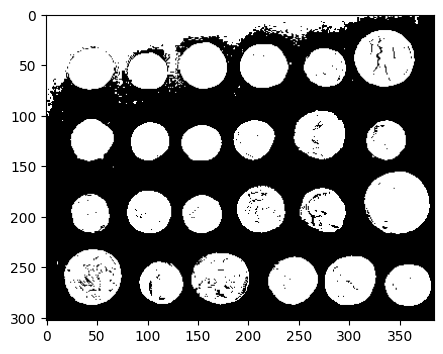

In [ ]:
# Describe the main steps required to perform segmentation of an RGB image
# using an unsupervised clustering algorithm
# (use other algorithms different than K-Means and compare the results)

#STEPS :
# 1. First reshape the image in dimensions Nxd where N is the number of pixels and d is the number of channels (N for example 515x515 and d in RGB is 3)
# 2. Initialize/create the model
# 3. Train the model with an array of pixels (image_reshaped.ravel() -> converts from 2D to 1D)
# 4. Do the predictions which gives us the regions. This gives us the segmented image but in an array of pixels
# 5. So the final step is to reshape it back with the dimensions of original image

#Gaussian Mixture Models
from sklearn import mixture

v_img = I.reshape(-1,1)  #here the image is grayscale

gmm = mixture.GaussianMixture(n_components=2).fit(v_img)
regions = gmm.fit_predict(v_img)
regions = np.logical_not(regions)

gmm_img = regions.reshape(img.shape[0],img.shape[1])

fig = plt.figure(figsize=(5,5))
plt.imshow(gmm_img,cmap='gray')
plt.show()

#Comparison according to KMeans :
# GMM provides a softer and more probabilistic segmentation.
# It models the pixel intensities using a mixture of Gaussians and allows for different variances per cluster.
# This gives a slightly more refined segmentation, especially in regions with overlapping intensities.

In [ ]:
#Extract the main texture features of this image

props = regionprops(label_image, intensity_image=I)
nregions = len(props)

props_texture = np.zeros((nregions, 5))
for i, p in enumerate(props):
    minr, minc, maxr, maxc = p.bbox
    I_sub = I[minr:maxr, minc:maxc]

    Iu8 = img_as_ubyte(I_sub)

    g = graycomatrix(Iu8, distances=[1], angles=[0], levels=256, normed=True, symmetric=True)

    props_texture[i, 0] = graycoprops(g, 'contrast')[0, 0]
    props_texture[i, 1] = graycoprops(g, 'dissimilarity')[0, 0]
    props_texture[i, 2] = graycoprops(g, 'homogeneity')[0, 0]
    props_texture[i, 3] = graycoprops(g, 'energy')[0, 0]
    props_texture[i, 4] = graycoprops(g, 'correlation')[0, 0]


df = pd.DataFrame(props_texture, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
df.head()

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,254.474130,7.573417,0.310996,0.033827,0.890400
1,7.050000,1.716667,0.551310,0.206828,0.408660
2,2.461538,0.974359,0.642464,0.270145,0.887256
3,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000


# Personal Discussion

The Computer Vision course was highly informative and rewarding, providing deep insights into both fundamental and advanced concepts like image processing, object detection, and deep learning. The lessons were well-structured and practical, bridging theory with real-world examples. The professor was knowledgeable and engaging, explaining concepts clearly and encouraging discussions. Thank you for this valuable experience!  